In [41]:
import torch 
import torchvision
import torch.nn as nn 
import torch.nn.functional as F 
import numpy as np 
import matplotlib.pyplot as plt 

In [111]:
image_size = 32
patch_size = 8
if image_size % patch_size != 0: 
    raise ValueError("Image size must be divisible by patch size. Got (32 and 8)")

image = torch.rand(10, image_size, image_size, 3) 


def patch_image(images, patch_size): 
    patches = []
    image_size = images.shape[-1]

    for row_idx in range(0, image_size, patch_size): 
        for col_idx in range(0, image_size, patch_size):
            patch = images[:, :, :, row_idx: row_idx + patch_size, col_idx: col_idx + patch_size]
            patches.append(patch)

    patches = torch.stack(patches, dim=-3) # (B, S+1, N, c, P, P)
    B, S, c, N, p, _ = patches.shape
    patches = patches.view(B, S, N, c, p*p) # (B, S+1, N, c, P**2)
    return patches

# print(len(patches))
# for i, patch in enumerate(patches): 
#     plt.imshow(patch[0])
#     plt.show()


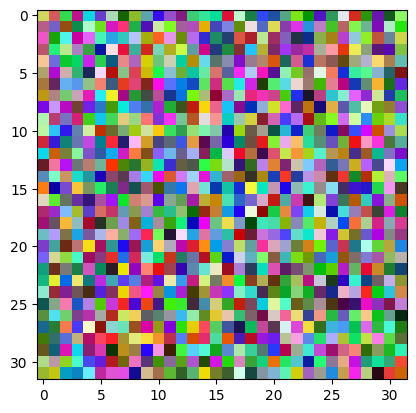

torch.Size([10, 5, 3, 32, 32])


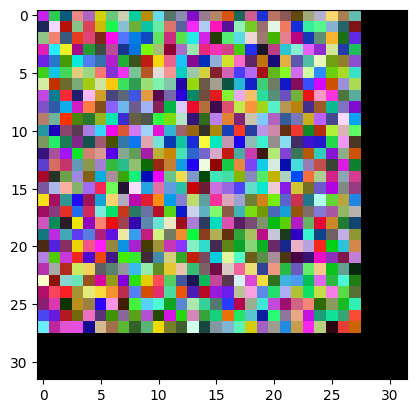

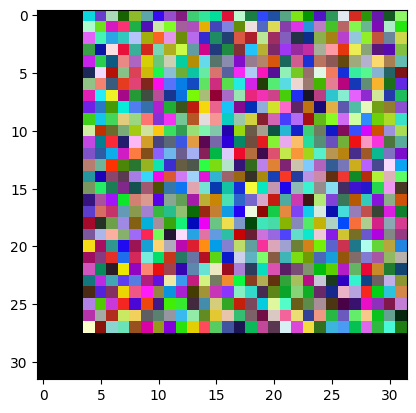

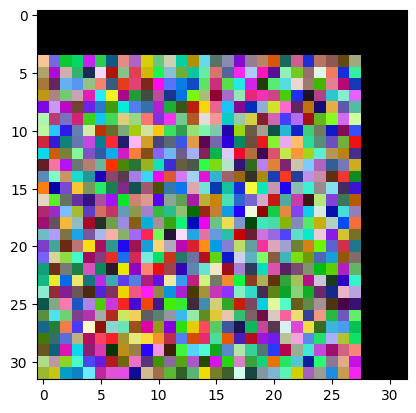

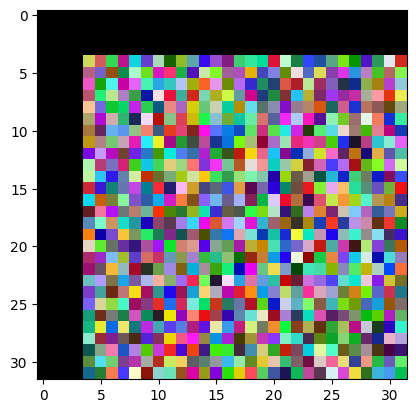

In [112]:
MODE = {
    "left-up" : {
        "crop_x" : patch_size // 2, 
        "crop_y" : patch_size // 2, 
        "pad" : (0, 0 , patch_size // 2, patch_size // 2)
    }, 
    "right-up" : {
        "crop_x" : 0, 
        "crop_y" : patch_size // 2, 
        "pad" : (patch_size // 2, 0, 0, patch_size // 2), 
    }, 
    "left-down" : {
        "crop_x" : patch_size // 2, 
        "crop_y" : 0, 
        "pad" : (0, patch_size // 2, patch_size // 2, 0), 
    }, 
    "right-down" : {
        "crop_x" : 0, 
        "crop_y" : 0, 
        "pad" : (patch_size // 2, patch_size // 2, 0, 0), 
    }, 
}


plt.imshow(image[0])
plt.show()

shifted = [image.permute(0, 3, 1, 2)]

for mode in MODE: 
    crop = torchvision.transforms.functional.crop(image.permute(0, 3, 1, 2), MODE[mode]["crop_x"], MODE[mode]["crop_y"], image_size - patch_size//2, image_size - patch_size//2) 
    pad = torchvision.transforms.functional.pad(crop, padding=MODE[mode]["pad"])
    shifted.append(pad)

shifted = torch.stack(shifted, dim=1)
print(shifted.shape)

for i in range(1, len(MODE)+1): 
    plt.imshow(shifted[0][i].permute(1, 2, 0))
    plt.show()


In [113]:
patch_image(shifted, 8).shape

torch.Size([10, 5, 16, 3, 64])

In [130]:
class ShiftedPatchTokenizer(nn.Module): 

    def __init__(self, image_size, patch_size, c_out): 
        super().__init__()
        if image_size % patch_size != 0: 
            raise ValueError("Image size must be divisible by patch size. Got (32 and 8)")

        self.patch_size = patch_size
        self.image_size = image_size
        
        c_in = int(5*3*patch_size**2)
        self.linear = nn.Linear(c_in, c_out, bias=False, device="cuda")

    def forward(self, x): 
        """
            x : (B, c, w, h)
            out : (B, N, N*c*P**2)
        """

        print("input : ", x.shape)
        shifts = self._shift_and_crop(x) 
        patches = self._patch_image(shifts)
        print("patches : ", patches.shape)
        out = self.linear(patches)
        return out

    def _patch_image(self, images): 
        """
            images : (B, 5, c, w, h)
            Output : patches : (B, 5, N*c*P**2)
        """
        patches = []

        for row_idx in range(0, self.image_size, self.patch_size): 
            for col_idx in range(0, self.image_size, self.patch_size):
                patch = images[:, :, :, row_idx: row_idx + self.patch_size, col_idx: col_idx + self.patch_size]
                patches.append(patch)

        patches = torch.stack(patches, dim=1) # (B, N, 5, c, P, P)
        B, N, S, c, p, _ = patches.shape
        print("before final patches : ", patches.shape)
        patches = patches.view(B, N, S*c*p*p) # (B, S+1, N*c*P**2)

        return patches
    
    def _shift_and_crop(self, images): 

        """
            Args : images : (B, c, w, h)
            Ouptut :  (B, 5, w, h, c)
        """

        shifted = [images]

        for mode in MODE: 
            crop = torchvision.transforms.functional.crop(
                images, 
                MODE[mode]["crop_x"], 
                MODE[mode]["crop_y"], 
                self.image_size - self.patch_size//2,
                self.image_size - self.patch_size//2
            ) 
            pad = torchvision.transforms.functional.pad(crop, padding=MODE[mode]["pad"])
            shifted.append(pad)

        shifted = torch.stack(shifted, dim=1) # (B, 5, c, w, h)
        
        return shifted

In [132]:
image_size = 32
patch_size = 8
if image_size % patch_size != 0: 
    raise ValueError("Image size must be divisible by patch size. Got (32 and 8)")

image = torch.rand(10, 3, image_size, image_size, device="cuda") 
tokenizer = ShiftedPatchTokenizer(image_size, patch_size, 256) 

input :  torch.Size([10, 3, 32, 32])
before final patches :  torch.Size([10, 16, 5, 3, 8, 8])
patches :  torch.Size([10, 16, 960])


torch.Size([10, 16, 256])